In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf


/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.24.3
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
train_mu0 = 0.
train_mu1 = 1.
train_rho01 = -0.6

train_sig0 = 1.0
train_sig1 = 1.5

train_cov00 = train_sig0 * train_sig0 
train_cov11 = train_sig1 * train_sig1
train_cov01 = train_rho01 * train_sig0 * train_sig1

train_cov = np.array( [[train_cov00, train_cov01], [train_cov01, train_cov11]] )
train_mu = np.array( [train_mu0, train_mu1])



true_mu0 = 0.2
true_mu1 = 0.8
true_rho01 = -0.6

true_sig0 = 0.9
true_sig1 = 1.3

true_cov00 = true_sig0 * true_sig0 
true_cov11 = true_sig1 * true_sig1
true_cov01 = true_rho01 * true_sig0 * true_sig1

true_cov = np.array( [[true_cov00, true_cov01], [true_cov01, true_cov11]] )
true_mu = np.array( [true_mu0, true_mu1])



#--- resolution is in same dimensions as features (not sigma/val)
res0 = 0.5
res1 = 0.8




## Plots to visualize these parameter choices

In [4]:

ngen_train = 100000
ngen_true = 10000

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, [res0, res1])

true_det_pts = np.random.normal( true_pts, [res0, res1])



<function matplotlib.pyplot.show(close=None, block=None)>

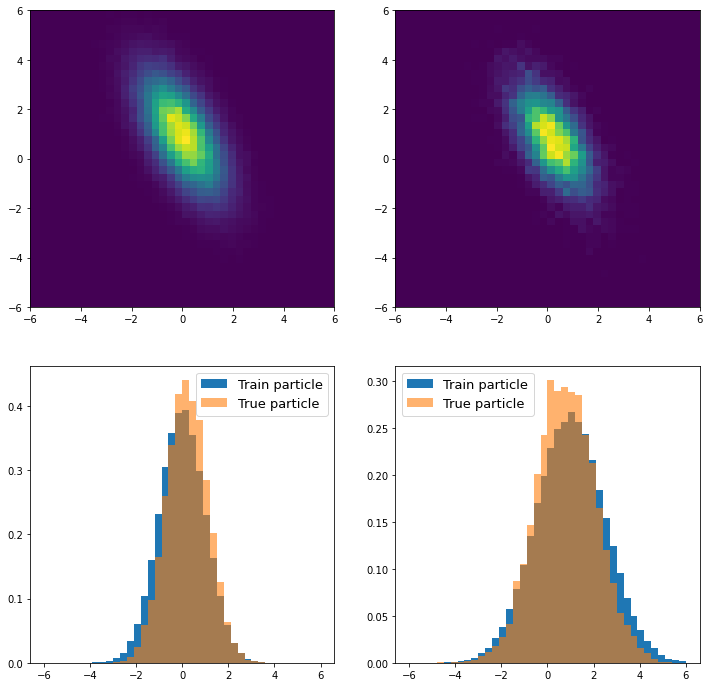

In [5]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

In [6]:
train_diff = train_det_pts - train_pts

In [7]:
diff_cov = np.cov( train_diff.T )

In [8]:
diff_cov

array([[ 0.25192673, -0.00187906],
       [-0.00187906,  0.64302631]])

In [9]:
np.sqrt(diff_cov[0,0])

0.5019230291789569

In [10]:
np.sqrt(diff_cov[1,1])

0.8018892139529186

<function matplotlib.pyplot.show(close=None, block=None)>

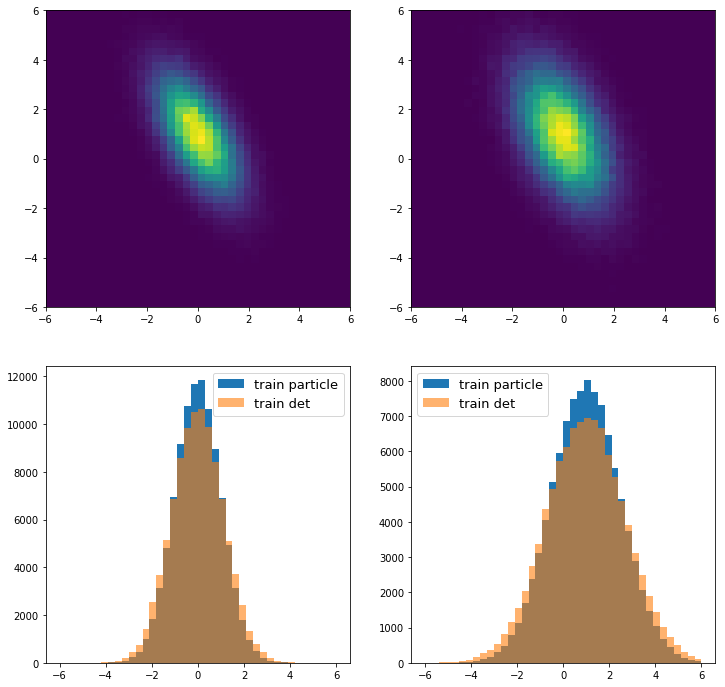

In [11]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

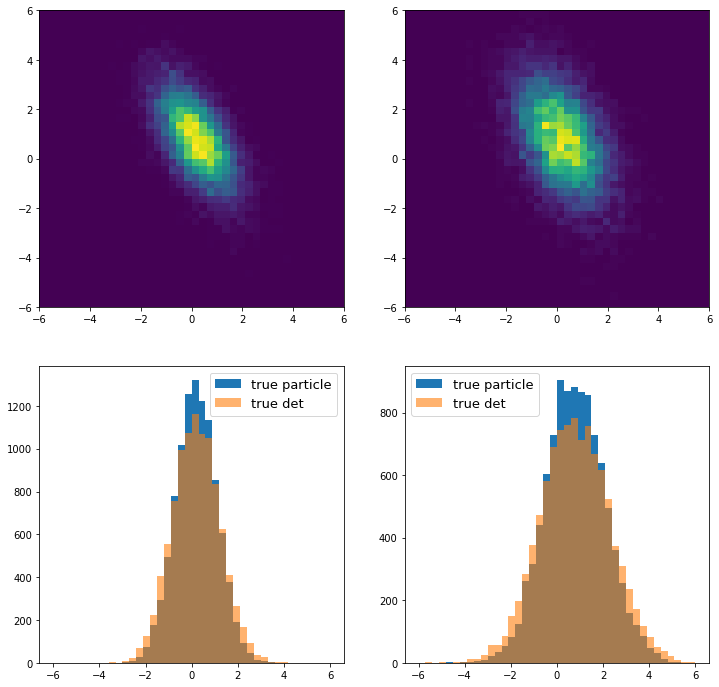

In [12]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)

ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

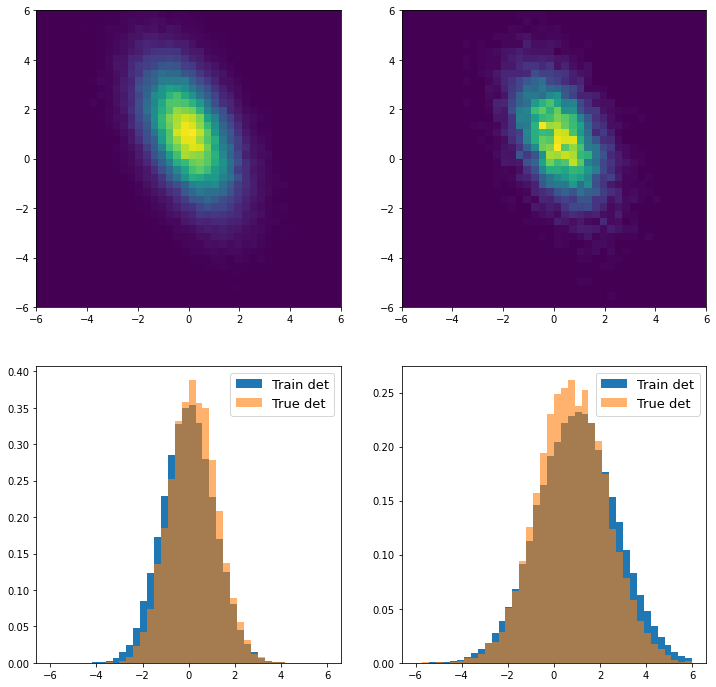

In [13]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)

ax[1][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

## Set up NN model for OmniFold

In [14]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

## Package the training data for OmniFold

In [15]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [16]:
%%time


verbose = True

of_niter = 4

of_weights = of.omnifold( train_both, true_det_pts, of_niter, model, verbose)




  shape of theta0_S : (100000, 2)
  shape of theta_unknown_S : (10000, 2)
  shape of xvals_1 :  (110000, 2)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10000,)
  shape of yvals_1 :  (110000,)



  shape of theta0_G : (100000, 2)
  shape of xvals_2 :  (200000, 2)
  shape of yvals_2 :  (200000,)




ITERATION: 1

   -- ITERATION 1  STEP 1

Epoch 1/20
9/9 [==============================] - 1s 27ms/step - loss: 0.7426 - accuracy: 0.5141 - val_loss: 0.6311 - val_accuracy: 0.4549
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 0.5812 - accuracy: 0.4544 - val_loss: 0.5118 - val_accuracy: 0.4549
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 0.4667 - accuracy: 0.4544 - val_loss: 0.4017 - val_accuracy: 0.4549
Epoch 4/20
9/9 [==============================] - 0s 9ms/step - loss: 0.3728 - accuracy: 0.4544 - val_loss: 0.3420 - val_accuracy: 0.4549
Epoch 5/20
9/9 [==============================] - 0s 9ms/step - loss: 0.3381 - accu

9/9 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.1741 - val_loss: 0.1243 - val_accuracy: 0.1685
Epoch 16/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.1668 - val_loss: 0.1244 - val_accuracy: 0.1719
Epoch 17/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1233 - accuracy: 0.2325 - val_loss: 0.1244 - val_accuracy: 0.2401
Epoch 18/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.1882 - val_loss: 0.1243 - val_accuracy: 0.1694
Epoch 19/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.1682 - val_loss: 0.1243 - val_accuracy: 0.1691
Epoch 20/20
10/10 [==============================] - 0s 2ms/step

   -- ITERATION 2  STEP 2

Epoch 1/20
75/75 [==============================] - 1s 4ms/step - loss: 0.2041 - accuracy: 0.2537 - val_loss: 0.1640 - val_accuracy: 0.2524
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.1648 - ac

75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1649 - val_accuracy: 0.2495
Epoch 12/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1650 - val_accuracy: 0.2495
Epoch 13/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1650 - val_accuracy: 0.2495
Epoch 14/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1649 - val_accuracy: 0.2495
Epoch 15/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1649 - val_accuracy: 0.2495
Epoch 16/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1649 - val_accuracy: 0.2495
Epoch 17/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2502 - val_loss: 0.1650 - val_accuracy: 0.2495
Epoch 18/20
75/75 [======

In [17]:
of_weights

array([[[0.04510603, 0.0208954 , 0.15067448, ..., 0.155174  ,
         0.07711869, 0.03720952],
        [0.05448498, 0.02090494, 0.08486098, ..., 0.12097765,
         0.09311523, 0.08491689]],

       [[1.05590057, 1.17027175, 1.02316558, ..., 0.97655588,
         0.87809271, 0.83201575],
        [0.05383262, 0.02381397, 0.08743507, ..., 0.11422463,
         0.08977148, 0.07531796]],

       [[0.99676746, 1.11998641, 1.03045142, ..., 1.05082595,
         0.96903318, 0.84501183],
        [0.053927  , 0.02656371, 0.08733261, ..., 0.11620937,
         0.08927175, 0.07249515]],

       [[0.98676258, 1.11999011, 0.99927539, ..., 1.02619708,
         0.99958855, 0.83664334],
        [0.05367287, 0.03104266, 0.0939066 , ..., 0.11431397,
         0.08917368, 0.06357333]]])

In [18]:
np.shape( of_weights)

(4, 2, 100000)

<function matplotlib.pyplot.show(close=None, block=None)>

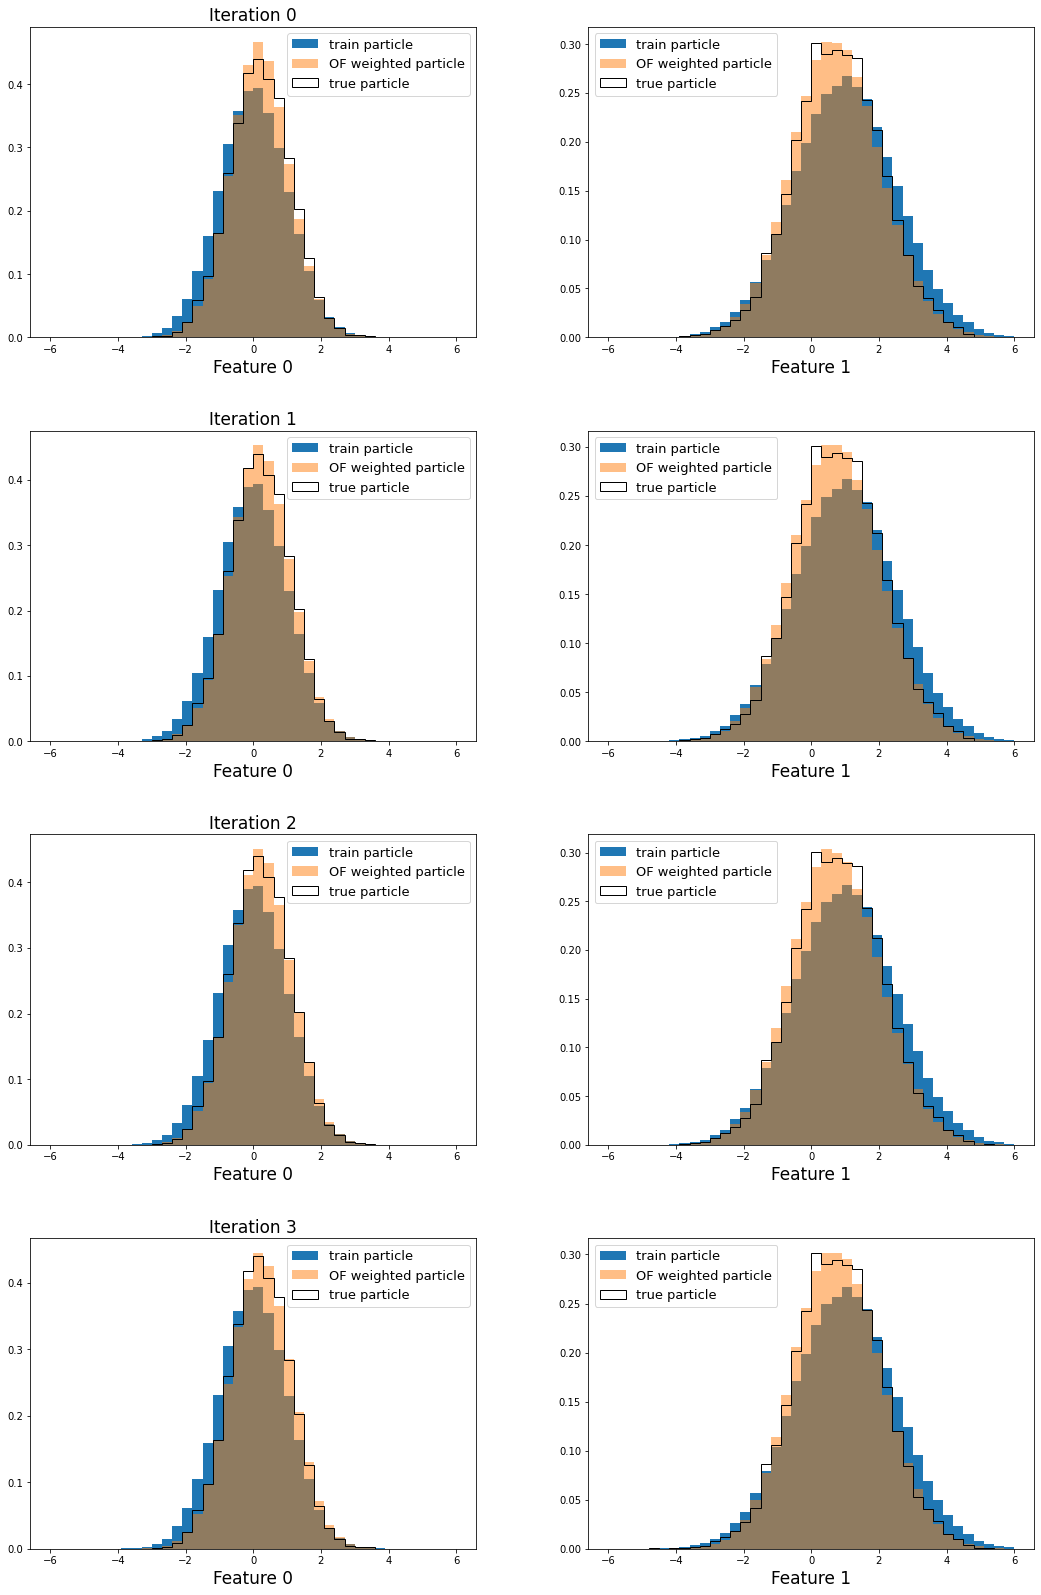

In [19]:


fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)



for ofi in range(0,of_niter) :

    ax[ofi][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][0].hist( train_pts[:,0], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )

    ax[ofi][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][1].hist( train_pts[:,1], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )


    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

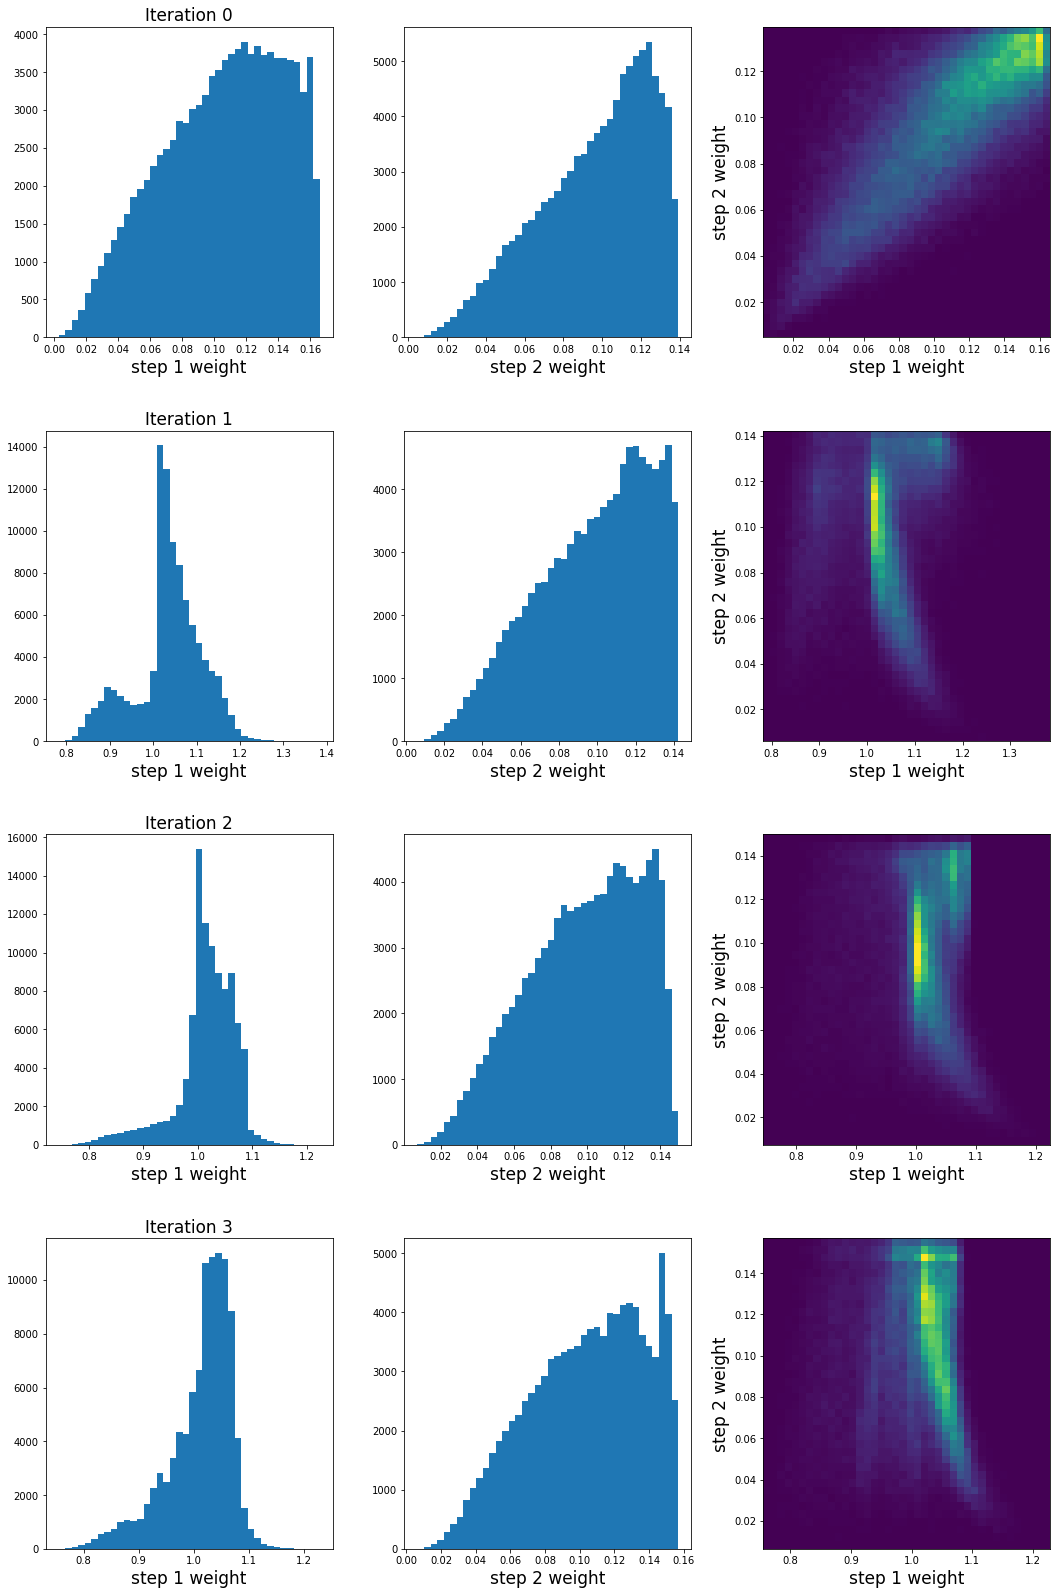

In [20]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

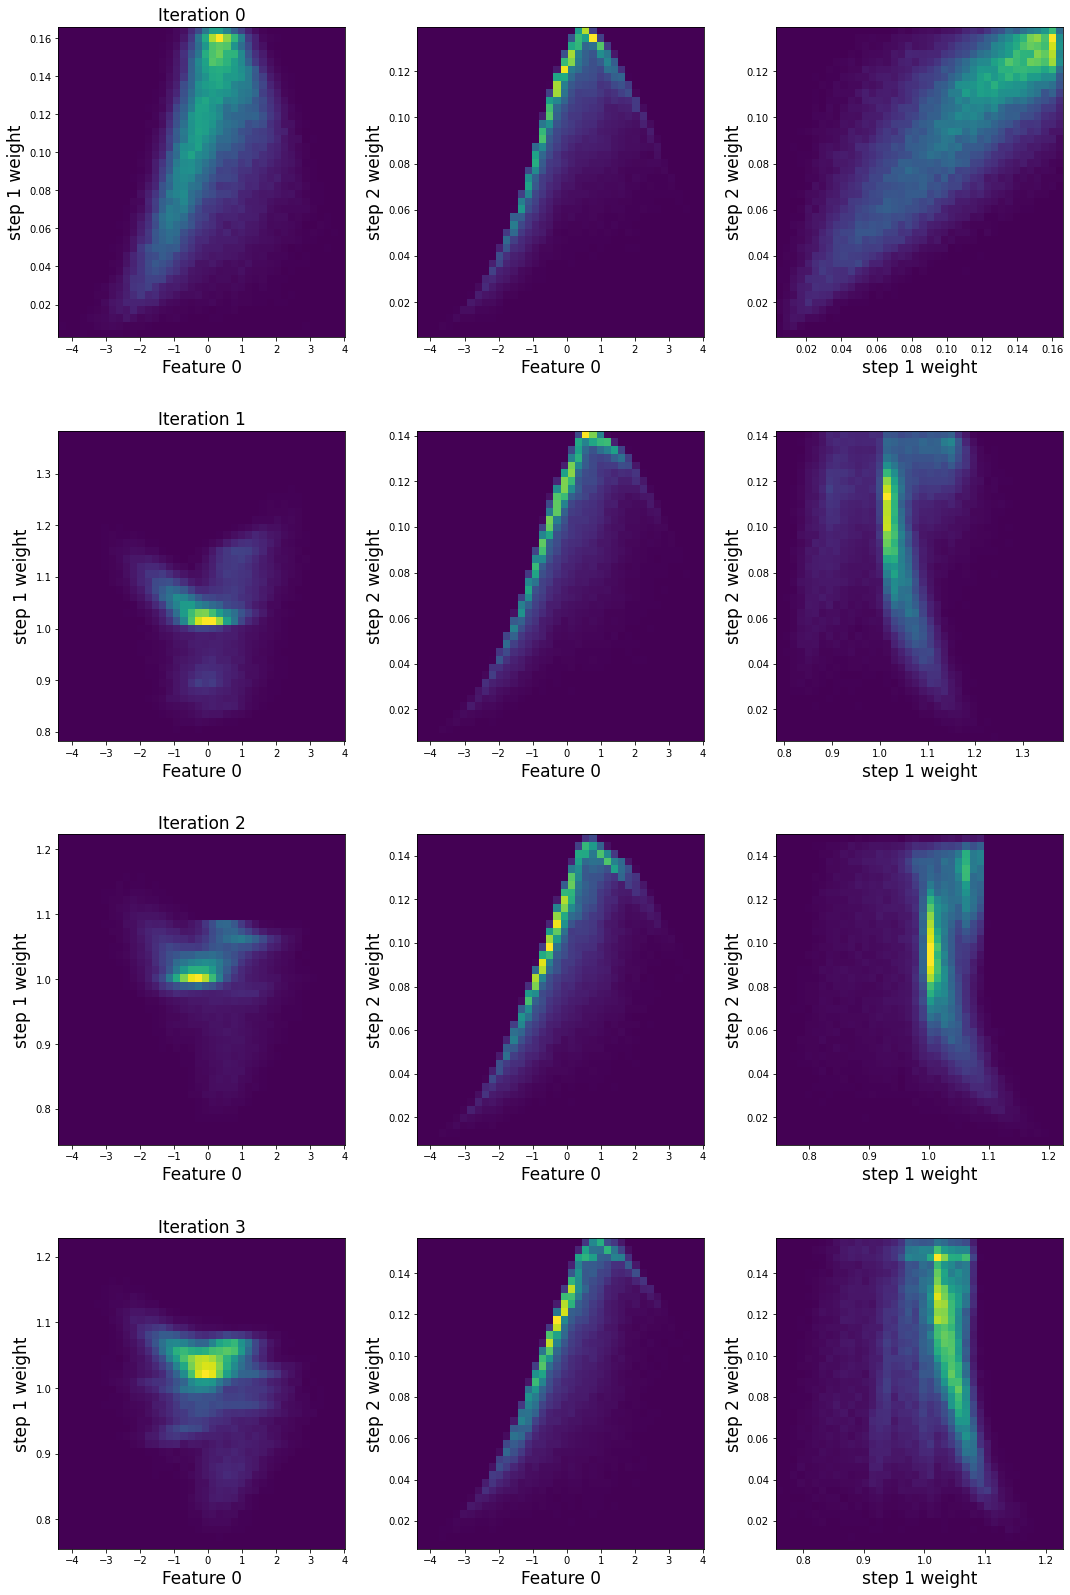

In [21]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,0], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,0], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

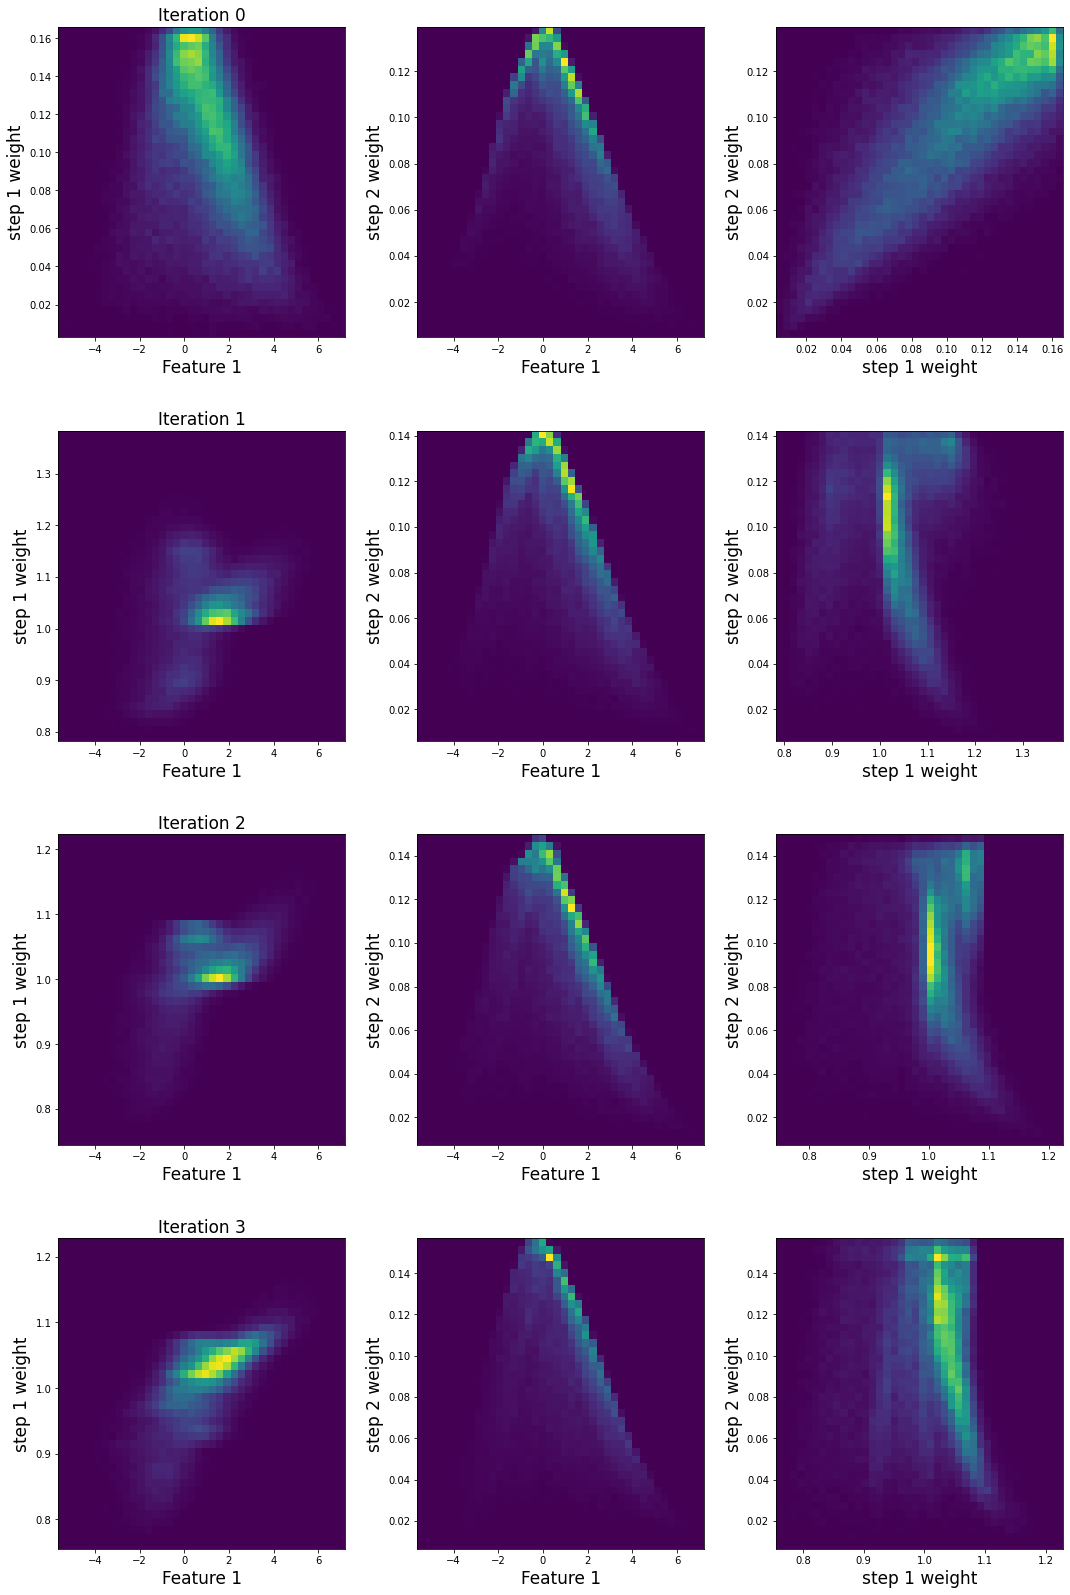

In [22]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,1], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,1], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [23]:
max_step2_weight = np.max( of_weights[3,1,:] )

<function matplotlib.pyplot.show(close=None, block=None)>

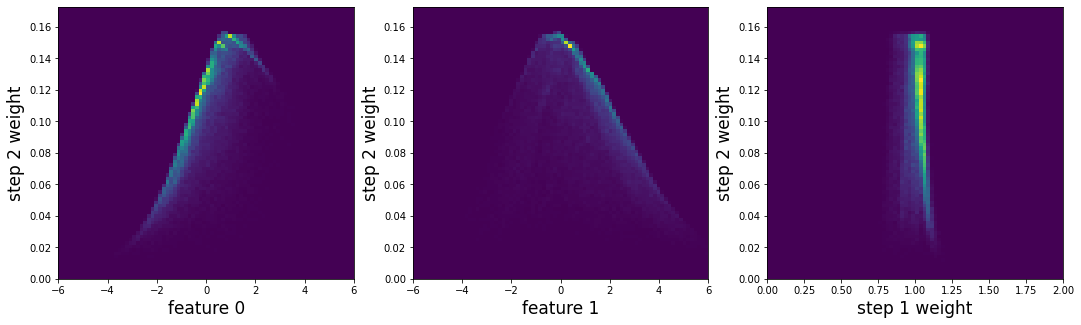

In [24]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))

hmin=-6
hmax=6
hbins=80

ax[0].hist2d( train_pts[:,0], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[1].hist2d( train_pts[:,1], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[2].hist2d( of_weights[3,0,:], of_weights[3,1,:], bins=[hbins,hbins], range=([0.,2.],[0.,1.1*max_step2_weight]))


lfontsize = 17

ax[0].set_xlabel( 'feature 0', fontsize=lfontsize )
ax[0].set_ylabel( 'step 2 weight', fontsize=lfontsize )


ax[1].set_xlabel( 'feature 1', fontsize=lfontsize )
ax[1].set_ylabel( 'step 2 weight', fontsize=lfontsize )

ax[2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
ax[2].set_ylabel( 'step 2 weight', fontsize=lfontsize )


plt.show


## Do the bootstrap samples in a loop

In [88]:
n_boot_samples = 15

do_bootstrap = True

verbose = False

bootstrap_weights = np.zeros( shape=(n_boot_samples, len(train_pts) ))

In [89]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = np.random.Generator.choice( true_det_pts, size=len(true_det_pts) )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        
    boot_of_weights = of.omnifold( train_both, boot_true_det_pts, of_niter, model, verbose)
    
    bootstrap_weights[bi] = boot_of_weights[3,1,:]
    


 Creating bootstrap sample   0
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   1
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   2
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   3
10/10 [==============================] - 0s 3ms/step

 Creating bootstrap sample   4
10/10 [==============================] - 0s 3ms/step

 Creating bootstrap sample   5
10/10 [==============================] - 0s 3ms/step

 Creating bootstrap sample   6
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   7
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   8
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   9
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample  10
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample  11
10/10 [==========================

10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample  13
10/10 [==============================] - 0s 4ms/step

 Creating bootstrap sample  14
10/10 [==============================] - 0s 2ms/step
CPU times: user 17min 12s, sys: 4min 8s, total: 21min 21s
Wall time: 8min 1s


In [90]:
bootstrap_weights

array([[0.06191958, 0.02012432, 0.0936762 , ..., 0.11370735, 0.09123879,
        0.06967977],
       [0.04977098, 0.01191593, 0.09380914, ..., 0.11562278, 0.08670765,
        0.07026057],
       [0.04616065, 0.01153151, 0.09213804, ..., 0.11366487, 0.08551451,
        0.06487799],
       ...,
       [0.05173302, 0.0147963 , 0.09614623, ..., 0.10448096, 0.08723108,
        0.06448885],
       [0.05495188, 0.02146842, 0.10003731, ..., 0.10870963, 0.09614693,
        0.0667526 ],
       [0.04746618, 0.0164453 , 0.09153148, ..., 0.09679508, 0.08422528,
        0.06597264]])

In [91]:
of_weights[3,1,:]

array([0.05367287, 0.03104266, 0.0939066 , ..., 0.11431397, 0.08917368,
       0.06357333])

In [92]:
bootstrap_weights[0]

array([0.06191958, 0.02012432, 0.0936762 , ..., 0.11370735, 0.09123879,
       0.06967977])

In [93]:
np.cov( bootstrap_weights[:,0])

array(3.58752758e-05)

In [94]:
bootstrap_weights[:,100]

array([0.10533715, 0.10314018, 0.10185952, 0.10077813, 0.11312297,
       0.10955624, 0.10129085, 0.11060507, 0.10884836, 0.10552844,
       0.11007632, 0.10767477, 0.11246734, 0.11261021, 0.10412079])

<function matplotlib.pyplot.show(close=None, block=None)>

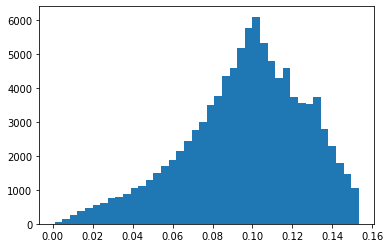

In [95]:
plt.hist( bootstrap_weights[1,:], bins=40)
plt.show

In [96]:
np.mean( bootstrap_weights, axis=0 )

array([0.05446   , 0.01361651, 0.09606333, ..., 0.11114353, 0.0893889 ,
       0.0659677 ])

In [97]:
bootstrap_w2 = bootstrap_weights * bootstrap_weights

In [98]:
bootstrap_w2

array([[0.00383403, 0.00040499, 0.00877523, ..., 0.01292936, 0.00832452,
        0.00485527],
       [0.00247715, 0.00014199, 0.00880016, ..., 0.01336863, 0.00751822,
        0.00493655],
       [0.00213081, 0.00013298, 0.00848942, ..., 0.0129197 , 0.00731273,
        0.00420915],
       ...,
       [0.00267631, 0.00021893, 0.0092441 , ..., 0.01091627, 0.00760926,
        0.00415881],
       [0.00301971, 0.00046089, 0.01000746, ..., 0.01181778, 0.00924423,
        0.00445591],
       [0.00225304, 0.00027045, 0.00837801, ..., 0.00936929, 0.0070939 ,
        0.00435239]])

In [99]:
bootstrap_variance = np.mean( bootstrap_w2, axis=0 ) - np.mean( bootstrap_weights, axis=0 ) * np.mean( bootstrap_weights, axis=0 )

In [100]:
bootstrap_variance

array([3.34835908e-05, 1.13984600e-05, 2.39852636e-05, ...,
       5.10051762e-05, 9.83997649e-06, 2.24694414e-05])

In [101]:
bootstrap_rms = np.sqrt( bootstrap_variance )

In [102]:
bootstrap_rms

array([0.0057865 , 0.00337616, 0.00489748, ..., 0.00714179, 0.00313687,
       0.00474019])

In [103]:
col_vec = np.array([[11],[22],[33]])

In [104]:
col_vec

array([[11],
       [22],
       [33]])

In [105]:
row_vec = col_vec.T

In [106]:
row_vec

array([[11, 22, 33]])

In [107]:
col_times_row = col_vec * row_vec

In [108]:
col_times_row

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [109]:
col_vec.shape

(3, 1)

In [110]:
row_vec.shape

(1, 3)

In [111]:
col_times_row.shape

(3, 3)

In [112]:
row_times_col = row_vec * col_vec

In [113]:
row_times_col

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [114]:
row_times_row = row_vec * row_vec

In [115]:
row_times_row

array([[ 121,  484, 1089]])

In [117]:
#row_dot_row = np.dot(row_vec,row_vec)

In [118]:
row_dot_col = np.dot(row_vec,col_vec)

In [119]:
row_dot_col

array([[1694]])

In [120]:
row_dot_col.shape

(1, 1)

In [121]:
col_dot_row = np.dot(col_vec,row_vec)

In [122]:
col_dot_row

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [123]:
bootstrap_weights.shape

(15, 100000)

In [124]:
bootstrap_weights.T

array([[0.06191958, 0.04977098, 0.04616065, ..., 0.05173302, 0.05495188,
        0.04746618],
       [0.02012432, 0.01191593, 0.01153151, ..., 0.0147963 , 0.02146842,
        0.0164453 ],
       [0.0936762 , 0.09380914, 0.09213804, ..., 0.09614623, 0.10003731,
        0.09153148],
       ...,
       [0.11370735, 0.11562278, 0.11366487, ..., 0.10448096, 0.10870963,
        0.09679508],
       [0.09123879, 0.08670765, 0.08551451, ..., 0.08723108, 0.09614693,
        0.08422528],
       [0.06967977, 0.07026057, 0.06487799, ..., 0.06448885, 0.0667526 ,
        0.06597264]])

In [125]:
bootstrap_weights.T.shape

(100000, 15)

In [126]:
bootstrap_weights_dot = np.dot( bootstrap_weights, bootstrap_weights.T )

In [127]:
bootstrap_weights_dot

array([[1080.51106999, 1047.22126741, 1091.62834169, 1031.72145976,
        1107.35583618, 1080.29202922, 1070.9498036 , 1096.75272295,
        1071.11053979, 1114.4905383 , 1097.25882492, 1062.50060032,
        1072.3749615 , 1113.01935375, 1065.09007375],
       [1047.22126741, 1019.08036623, 1059.96283428, 1001.85059888,
        1076.43908199, 1050.04849384, 1040.54516694, 1064.7551109 ,
        1041.39731756, 1083.2187656 , 1066.37825577, 1032.54079814,
        1041.03583066, 1080.32116293, 1034.65205339],
       [1091.62834169, 1059.96283428, 1109.56858997, 1046.77930676,
        1122.48026762, 1093.67986643, 1085.9990833 , 1110.76086371,
        1087.62935119, 1128.80345399, 1110.90352196, 1078.71903769,
        1086.80202354, 1128.6137343 , 1080.69289685],
       [1031.72145976, 1001.85059888, 1046.77930676,  989.78054262,
        1061.27797056, 1033.73445381, 1025.83608678, 1050.5842595 ,
        1027.31089613, 1067.356433  , 1051.2234058 , 1019.46211521,
        1027.14564561,

In [128]:
bootstrap_weights_dot.shape

(15, 15)

In [129]:
#bootstrap_weights_dot2 = np.dot( bootstrap_weights.T, bootstrap_weights )

In [130]:
#bootstrap_weights_dot2

In [131]:
bootstrap_weights[:,0]

array([0.06191958, 0.04977098, 0.04616065, 0.04999998, 0.05548704,
       0.06366473, 0.06485961, 0.05894682, 0.05066719, 0.04829995,
       0.05801111, 0.05496131, 0.05173302, 0.05495188, 0.04746618])

In [132]:
bootstrap_weights[:,1]

array([0.02012432, 0.01191593, 0.01153151, 0.01195448, 0.01435974,
       0.0106815 , 0.0118734 , 0.01297355, 0.0146611 , 0.00922677,
       0.01214462, 0.01009067, 0.0147963 , 0.02146842, 0.0164453 ])

In [133]:
combined = np.column_stack( (bootstrap_weights[:,0], bootstrap_weights[:,1]))

In [134]:
combined

array([[0.06191958, 0.02012432],
       [0.04977098, 0.01191593],
       [0.04616065, 0.01153151],
       [0.04999998, 0.01195448],
       [0.05548704, 0.01435974],
       [0.06366473, 0.0106815 ],
       [0.06485961, 0.0118734 ],
       [0.05894682, 0.01297355],
       [0.05066719, 0.0146611 ],
       [0.04829995, 0.00922677],
       [0.05801111, 0.01214462],
       [0.05496131, 0.01009067],
       [0.05173302, 0.0147963 ],
       [0.05495188, 0.02146842],
       [0.04746618, 0.0164453 ]])

In [135]:
pair_cov = np.cov( combined )

In [136]:
pair_cov

array([[0.00087342, 0.00079108, 0.00072367, 0.00079506, 0.00085946,
        0.00110722, 0.00110729, 0.00096073, 0.00075244, 0.00081654,
        0.0009585 , 0.00093769, 0.00077189, 0.00069973, 0.00064826],
       [0.00079108, 0.0007165 , 0.00065544, 0.00072011, 0.00077844,
        0.00100284, 0.0010029 , 0.00087016, 0.00068151, 0.00073956,
        0.00086814, 0.00084929, 0.00069912, 0.00063376, 0.00058715],
       [0.00072367, 0.00065544, 0.00059959, 0.00065874, 0.0007121 ,
        0.00091738, 0.00091743, 0.00079601, 0.00062343, 0.00067654,
        0.00079416, 0.00077692, 0.00063954, 0.00057975, 0.00053711],
       [0.00079506, 0.00072011, 0.00065874, 0.00072373, 0.00078235,
        0.00100789, 0.00100794, 0.00087454, 0.00068493, 0.00074328,
        0.00087251, 0.00085356, 0.00070264, 0.00063695, 0.0005901 ],
       [0.00085946, 0.00077844, 0.0007121 , 0.00078235, 0.00084573,
        0.00108953, 0.00108959, 0.00094538, 0.00074042, 0.00080349,
        0.00094318, 0.0009227 , 0.00075955, 

In [137]:
combined_row = np.row_stack( (bootstrap_weights[:,0], bootstrap_weights[:,2]))

In [138]:
combined_row

array([[0.06191958, 0.04977098, 0.04616065, 0.04999998, 0.05548704,
        0.06366473, 0.06485961, 0.05894682, 0.05066719, 0.04829995,
        0.05801111, 0.05496131, 0.05173302, 0.05495188, 0.04746618],
       [0.0936762 , 0.09380914, 0.09213804, 0.08669707, 0.09990267,
        0.10724897, 0.09299397, 0.09639199, 0.10193665, 0.09710819,
        0.09914712, 0.09218493, 0.09614623, 0.10003731, 0.09153148]])

In [139]:
pair_cov_rs = np.cov( combined_row )

In [140]:
pair_cov_rs

array([[3.58752758e-05, 1.12349872e-05],
       [1.12349872e-05, 2.56984967e-05]])

In [141]:
pair_cor = np.corrcoef(combined_row)

In [142]:
pair_cor

array([[1.        , 0.37001651],
       [0.37001651, 1.        ]])

In [143]:
pair_cor[0,1]

0.3700165064843097

In [144]:
ncalc = 10000
corr_array = np.zeros( ncalc )

for i in range(ncalc) :
    pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,0], bootstrap_weights[:,i+1]) ))
    corr_array[i] = pair_cor[0,1]


In [145]:
corr_array

array([ 0.10550303,  0.37001651, -0.13699052, ..., -0.09901344,
        0.02717052,  0.02972407])

<function matplotlib.pyplot.show(close=None, block=None)>

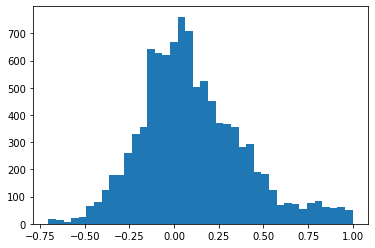

In [146]:
plt.hist( corr_array, bins=40)
plt.show